<a href="https://colab.research.google.com/github/kingsdigitallab/lwm-davizct/blob/main/notebooks/LwM_DAVIZCT_01_Explore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Zooniverse](https://zooniverse.org) data exploration using [Zoonyper](https://github.com/kingsdigitallab/zoonyper)

## Instructions

- [Download data from Zooniverse](https://github.com/Living-with-machines/zoonyper/blob/v0.1.0/docs/source/getting-started/tutorials/setting-up-your-first-project.rst)
    - If the notebook is running in Colab, it expects the data to be stored in Google Drive
- Run the cells to the [Settings](#settings) section
- Set up the data path settings
- Run the rest of the notebook



## System set up

In [1]:
ipython = get_ipython()
IN_COLAB = "google.colab" in str(ipython)

In [2]:
%%capture
if IN_COLAB:
    !curl -sSL https://install.python-poetry.org | python - && \
        if [ ! -d "zoonyper" ] ; then git clone https://github.com/kingsdigitallab/zoonyper.git; fi && \
        cd zoonyper && \
        git pull && \
        ~/.local/bin/poetry build && \
        pip install dist/zoonyper-0.1.0.tar.gz ipylab

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

import base64
import json
import os
import time

import ipywidgets as widgets
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from ipylab import JupyterFrontEnd
from IPython.display import Image
from IPython.display import Markdown as md
from IPython.display import display
from wordcloud import WordCloud

from zoonyper.project import Project

app = JupyterFrontEnd()

pd.options.plotting.backend = "plotly"

plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["figure.dpi"] = 100
plt.rcParams["font.size"] = 12

### Helper functions

In [4]:
def info(msg):
    return md(f">ℹ️ {msg}")


def mm(graph):
    graphbytes = graph.strip().encode("ascii")
    base64_bytes = base64.b64encode(graphbytes)
    base64_string = base64_bytes.decode("ascii")
    display(Image(url=f"https://mermaid.ink/img/{base64_string}"))


def show_wordcloud(words):
    wordcloud = WordCloud(background_color="white", width=4096, height=2304).fit_words(
        words
    )

    plt.axis("off")
    plt.imshow(wordcloud, interpolation="quadric")
    plt.show()

## Settings
<a id="settings"></a>

Fill the form below with the paths to the Zooniverse data. If running on Colab, the notebook expects the data to be in Google Drive.

In [5]:
data_path = "../data/0_raw"
subjects_path = "../data/downloads"

if IN_COLAB:
    from google.colab import drive

    drive.mount("/content/drive")
    data_path = "drive/My Drive/Colab Data/lwm/davizct/data/0_raw"
    subjects_path = "drive/My Drive/Colab Data/lwm/davizct/data/downloads"

form_item_layout = widgets.Layout(
    display="flex", flex_flow="column", justify_content="space-between"
)

data_path_widget = widgets.Text(value=data_path)
subjects_path_widget = widgets.Text(value=subjects_path)
disambiguate_subjects_widget = widgets.Checkbox(
    value=not IN_COLAB,
    tooltip="This is only needed if there are duplicate subjects in the data",
)

settings_form = widgets.Box(
    [
        widgets.Box(
            [widgets.Label("Path to Zooniverse data exports"), data_path_widget],
            layout=form_item_layout,
        ),
        widgets.Box(
            [
                widgets.Label(
                    "Disambiguate subjects? Only needed if there are duplicate subjects in the data"
                ),
                disambiguate_subjects_widget,
            ],
            layout=form_item_layout,
        ),
        widgets.Box(
            [
                widgets.Label(
                    "Path to Zooniverse subjects images, for subject disambiguation"
                ),
                subjects_path_widget,
            ],
            layout=form_item_layout,
        ),
    ],
    layout=widgets.Layout(
        display="flex",
        flex_flow="column",
        border="solid 1px",
        align_items="stretch",
        width="auto",
    ),
)

display(settings_form)

Box(children=(Box(children=(Label(value='Path to Zooniverse data exports'), Text(value='../data/0_raw')), layo…

In [6]:
data_path = data_path_widget.value
subjects_path = subjects_path_widget.value
disambiguate_subjects = disambiguate_subjects_widget.value

stat = os.stat(os.path.join(data_path, "workflows.csv"))
export_date = time.ctime(stat.st_mtime)

info(f"**This notebook is using data exported on {export_date}**")

>ℹ️ **This notebook is using data exported on Tue Mar 21 13:52:18 2023**

## Project data model

In [7]:
mm(
    """
erDiagram
    workflow ||--|{ annotation : has
    workflow }|--o{ subject_set: has
    subject_set }|--|{ subject: contains
    annotation ||--|| subject: on
    user ||..|{ annotation : makes
    user ||..|{ comment : writes
    tag }|--|{ comment : in
    comment ||--o{ subject : "written about"
"""
)

## Project

In [8]:
project = Project(data_path)

### Disambiguate subjects
> **Warning: Depending on the amount of data, this step may be too time consuming to run on Colab.**

In [9]:
subjects_df = project.subjects

if disambiguate_subjects and not project.are_subjects_disambiguated():
    subjects_df = project.disambiguate_subjects(subjects_path)

⚠ Warning: Note that the subject IDs have not yet been
disambiguated. If you want to do so, run the
`.disambiguate_subjects(<download-dir>)` method.
⚠ Warning: Note that the subject IDs have not yet been
disambiguated. If you want to do so, run the
`.disambiguate_subjects(<download-dir>)` method.
⚠ Warning: Note that the subject IDs have not yet been
disambiguated. If you want to do so, run the
`.disambiguate_subjects(<download-dir>)` method.


100%|████████████████████████████████████████████| 51488/51488 [00:42<00:00, 1221.22it/s]


In [10]:
workflows = project.workflows
workflows.head(2)

display_name  version  active  \
workflow_id                                                             
12038        Classify and summarise articles (set 1)        1   False   
12038        Classify and summarise articles (set 1)        2   False   

             classifications_count  pairwise  grouped  prioritized  \
workflow_id                                                          
12038                            8     False    False        False   
12038                            8     False    False        False   

            primary_language first_task tutorial_subject_id  \
workflow_id                                                   
12038                     en                                  
12038                     en         T0                       

             retired_set_member_subjects_count  \
workflow_id                                      
12038                                        0   
12038                                        0   

                                                         tasks  \
workflow_id                                                      
12038                                                       {}   
12038        {"T0":{"help":"T0.help","type":"single","answe...   

                                                    retirement aggregation  \
workflow_id                                                                  
12038        {"options":{"count":5},"criteria":"classificat...          {}   
12038        {"options":{"count":5},"criteria":"classificat...          {}   

                                                      strings  minor_version  
workflow_id                                                                   
12038                                                      {}              1  
12038        {"T0.help":"","T0.question":"Enter a question."}              2

ℹ Information: Note that the subject IDs have been disambiguated
and the information can be found in the
`subject_id_disambiguated` column.


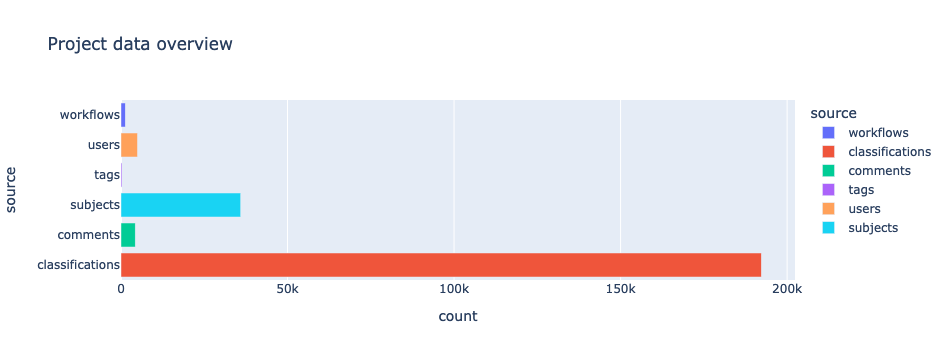

In [11]:
source = [
    "workflows",
    "classifications",
    "comments",
    "tags",
    "users",
    "subjects",
]

count = [
    workflows.shape[0],
    project.classifications.shape[0],
    project.comments.shape[0],
    project.tags["name"].nunique(),
    project.classifications["user_name"].nunique(),
]

if project.are_subjects_disambiguated():
    count.append(subjects_df["subject_id_disambiguated"].nunique())
else:
    count.append(subjects_df.shape[0])

meta_df = pd.DataFrame(dict(source=source, count=count))

fig = px.bar(
    meta_df, x="count", y="source", color="source", title="Project data overview"
)
fig.update_layout(yaxis=dict(categoryorder="category ascending"))
fig.show()

## Users

In [12]:
users = (
    project.classifications[["user_name", "user_group_ids"]]
    .value_counts("user_name")
    .reset_index(name="count")
)

info(f"There are **{users.shape[0]}** different users in the project.")

>ℹ️ There are **4938** different users in the project.

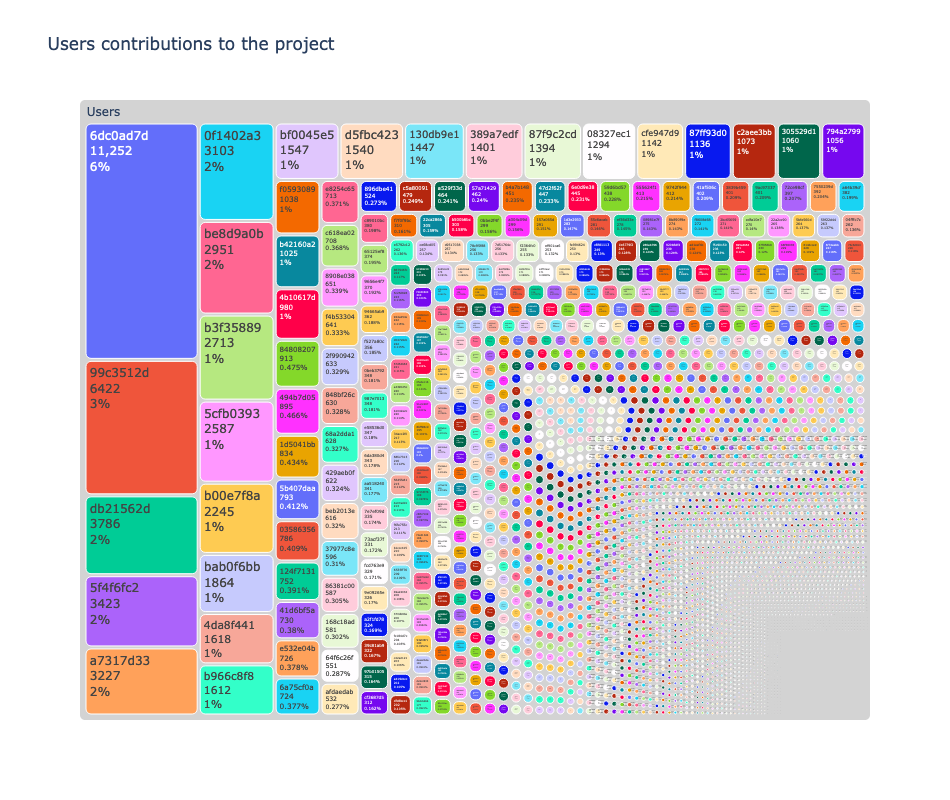

In [13]:
fig = px.treemap(
    users,
    path=[px.Constant("Users"), "user_name"],
    values="count",
    title=f"Users contributions to the project",
    height=800,
)
fig.update_traces(
    marker=dict(cornerradius=5),
    root_color="lightgrey",
    textinfo="label+value+percent root",
)
fig.show()

## Comments

In [14]:
# there are names in the comments, is that a problem
comments = project.comments
comments["focus_type"] = comments["focus_type"].fillna("")
comments["len"] = comments["body"].str.len()
comments.head()

body  focus_id  \
comment_id                                                                
1832647     To get things started I've collected comments ...         0   
1833213     Image zoom! If you have a tall column of text,...         0   
1833591     Other requests / comments from Andre and Emma:...         0   
1834282     Hi Mia, replying to your email here... If I re...         0   
1837199     On the image zoom thing - it turns out that (s...         0   

           focus_type  user_id user_login  created_at  len  
comment_id                                                  
1832647                1926730   miaridge  2019-09-16  443  
1833213                1926730   miaridge  2019-09-16  162  
1833591                1926730   miaridge  2019-09-16  830  
1834282                1928640  andrepiza  2019-09-17  476  
1837199                1926730   miaridge  2019-09-19  561

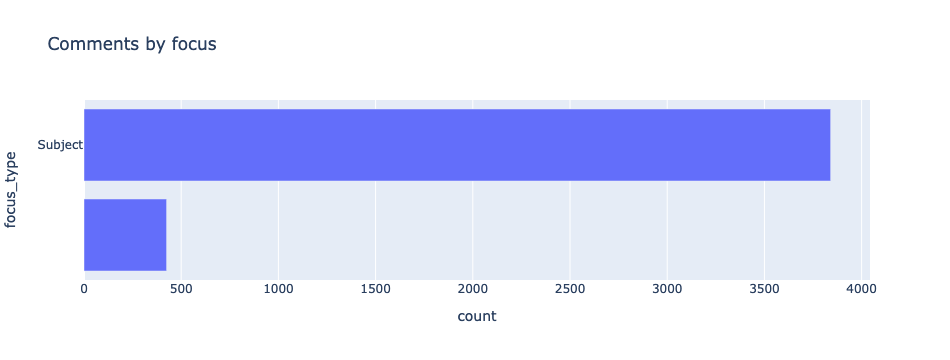

In [15]:
fig = px.bar(
    comments.value_counts("focus_type").reset_index(name="count"),
    y="focus_type",
    x="count",
    title="Comments by focus",
)
fig.update_layout(yaxis=dict(categoryorder="category ascending"))
fig.show()

## Tags

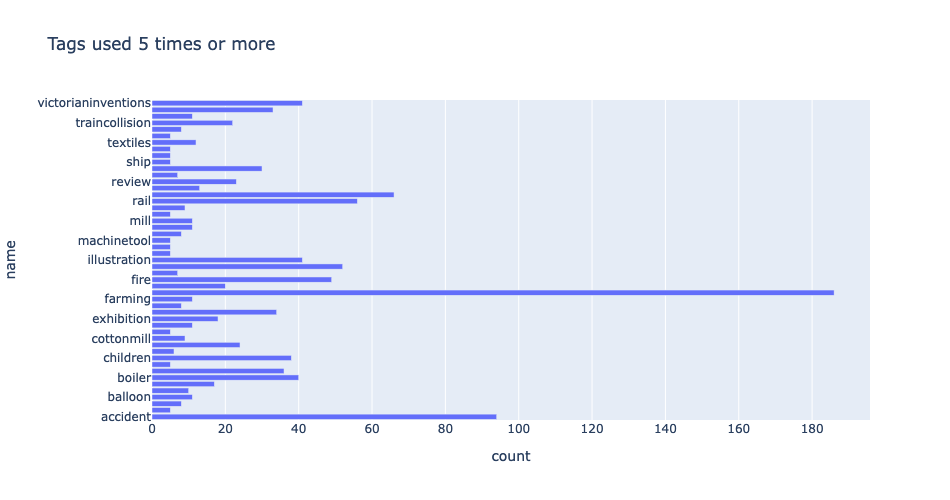

In [16]:
tags = project.tags.value_counts("name").reset_index(name="count")

fig = px.bar(
    tags[tags["count"] > 4],
    x="count",
    y="name",
    title="Tags used 5 times or more",
    height=500,
)
fig.update_layout(yaxis=dict(categoryorder="category ascending"))
fig.show()

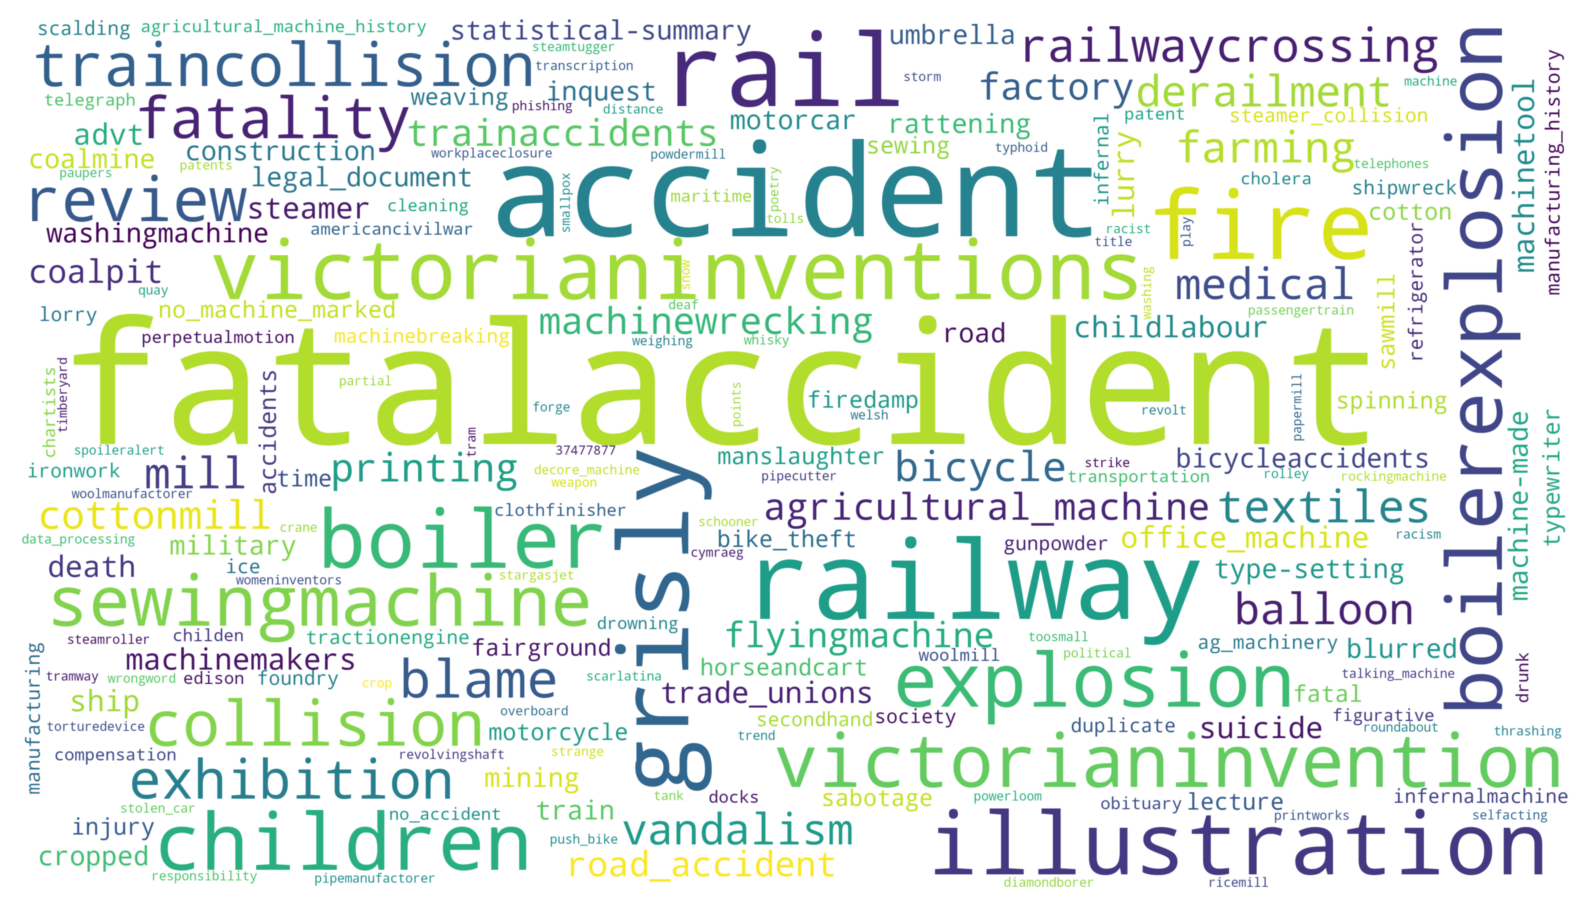

In [17]:
show_wordcloud(tags.set_index("name")["count"].to_dict())

## Workflows

In [18]:
workflows["start_date"] = workflows.apply(
    lambda x: project.classifications[project.classifications["workflow_id"] == x.name][
        "created_at"
    ].min(),
    axis=1,
)
workflows["end_date"] = workflows.apply(
    lambda x: project.classifications[project.classifications["workflow_id"] == x.name][
        "created_at"
    ].max(),
    axis=1,
)

workflows.head(2)

display_name  version  active  \
workflow_id                                                             
12038        Classify and summarise articles (set 1)        1   False   
12038        Classify and summarise articles (set 1)        2   False   

             classifications_count  pairwise  grouped  prioritized  \
workflow_id                                                          
12038                            8     False    False        False   
12038                            8     False    False        False   

            primary_language first_task tutorial_subject_id  \
workflow_id                                                   
12038                     en                                  
12038                     en         T0                       

             retired_set_member_subjects_count  \
workflow_id                                      
12038                                        0   
12038                                        0   

                                                         tasks  \
workflow_id                                                      
12038                                                       {}   
12038        {"T0":{"help":"T0.help","type":"single","answe...   

                                                    retirement aggregation  \
workflow_id                                                                  
12038        {"options":{"count":5},"criteria":"classificat...          {}   
12038        {"options":{"count":5},"criteria":"classificat...          {}   

                                                      strings  minor_version  \
workflow_id                                                                    
12038                                                      {}              1   
12038        {"T0.help":"","T0.question":"Enter a question."}              2   

             start_date    end_date  
workflow_id                          
12038        2019-09-12  2021-06-21  
12038        2019-09-12  2021-06-21

In [19]:
workflows_timeline_df = (
    workflows.reset_index()
    .groupby(["workflow_id", "display_name", "start_date", "end_date", "active"])
    .count()
    .reset_index()
    .sort_values(by="display_name", key=lambda x: x.str.lower())
)

info(
    f"There are **{workflows_timeline_df.shape[0]}** different workflows in the project, "
    f"of which **{workflows_timeline_df[workflows_timeline_df['active'] == True].shape[0]}** are active."
)

>ℹ️ There are **21** different workflows in the project, of which **5** are active.

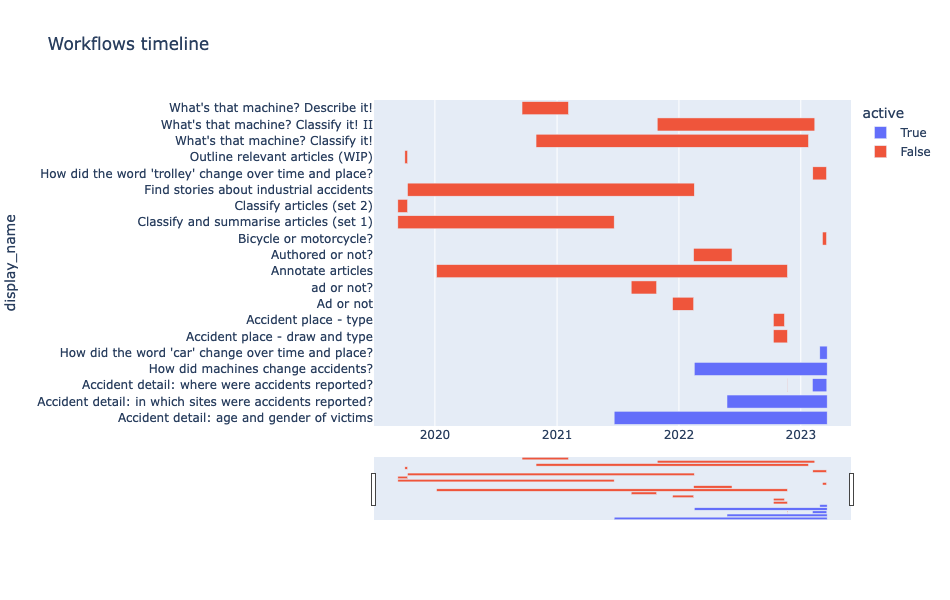

In [20]:
px.timeline(
    workflows_timeline_df,
    x_start="start_date",
    x_end="end_date",
    y="display_name",
    color="active",
    title="Workflows timeline",
    height=600,
).update_xaxes(rangeslider_visible=True)

## Focus on a workflow

In [21]:
workflow_options = list(set(workflows["display_name"].items()))
workflow_options = sorted(
    [(name, id) for id, name in workflow_options], key=lambda x: x[0]
)

workflow_widget = widgets.Dropdown(
    options=workflow_options,
    value=20921,
    description="Select a workflow:",
    layout=widgets.Layout(width="auto"),
    style=dict(description_width="auto"),
)

if not IN_COLAB:
    workflow_widget.observe(
        lambda x: JupyterFrontEnd().commands.execute("notebook:run-all-below"),
        names="value",
    )

Select a workflow from the dropdown.

If the notebook is running in Colab, after selecting a new workflow, manually run the cells below.
If the notebook is running in JupyterLab, the cells will run automatically after changing the workflow.

In [22]:
display(workflow_widget)

Dropdown(description='Select a workflow:', index=14, layout=Layout(width='auto'), options=(('Accident detail: …

In [23]:
workflow_id = workflow_widget.value
workflow = workflows.loc[workflow_id]
workflow_name = workflow["display_name"].iloc[0]

md(
    f"""### *{workflow_name}*
   _This workflow is **{'not ' if workflow.iloc[0]['active'] else ''}active**_.
   """
)

### *How did machines change accidents?*
   _This workflow is **not active**_.
   

#### Annotations

In [24]:
subjects_columns = ["subject_set_id"]
subject_id_column = "subject_ids"

if project.are_subjects_disambiguated():
    subject_id_column = "subject_id_disambiguated"
    subjects_columns.append(subject_id_column)

classifications = project.classifications[
    project.classifications["workflow_id"] == workflow_id
]
classifications = classifications.merge(
    subjects_df[subjects_columns],
    left_on="subject_ids",
    right_index=True,
)

classifications.head(2)

ℹ Information: Note that the subject IDs have been disambiguated
and the information can be found in the
`subject_id_disambiguated` column.


user_name user_ip  workflow_id  workflow_version  \
classification_id                                                    
398718404          130db9e1  11589b        20921              3.20   
399691550          db21562d  bc695a        20921              4.49   

                   created_at  gold_standard  expert  subject_ids  \
classification_id                                                   
398718404          2022-02-24          False   False     73320654   
399691550          2022-03-01          False   False     73320654   

                   user_logged_in source  ... seconds T1  \
classification_id                         ...              
398718404                    True    api  ...      69      
399691550                    True    api  ...      13      

                                                             T0  T3 T2 T4 T6  \
classification_id                                                              
398718404          There are no relevant articles on this image                
399691550          There are no relevant articles on this image                

                  T5  subject_set_id  subject_id_disambiguated  
classification_id                                               
398718404                     102701                       585  
399691550                     102701                       585  

[2 rows x 39 columns]

In [25]:
number_of_subjects = classifications[subject_id_column].nunique()
number_of_subject_sets = classifications["subject_set_id"].nunique()

md(
    f"""The workflow *{workflow_name}*
    contains *{number_of_subjects}* subjects 
    from *{number_of_subject_sets}* subject sets."""
)

The workflow *How did machines change accidents?*
    contains *13330* subjects 
    from *23* subject sets.

In [26]:
classifications_by_day = classifications.value_counts("created_at").reset_index(
    name="count"
)
classifications_by_day = classifications_by_day.sort_values("created_at")
classifications_by_day["cumulative_count"] = classifications_by_day["count"].cumsum()
classifications_by_day = classifications_by_day.sort_values("created_at")

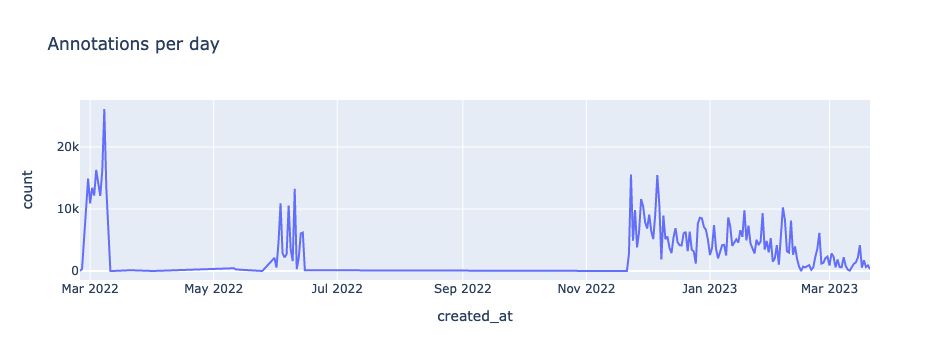

In [27]:
fig = classifications_by_day.plot.line(
    x="created_at", y="count", title="Annotations per day"
)
fig.show()

In [28]:
info(
    f"The workflow *{workflow_name}* has been worked on during **{classifications_by_day.shape[0]}** days."
)

>ℹ️ The workflow *How did machines change accidents?* has been worked on during **155** days.

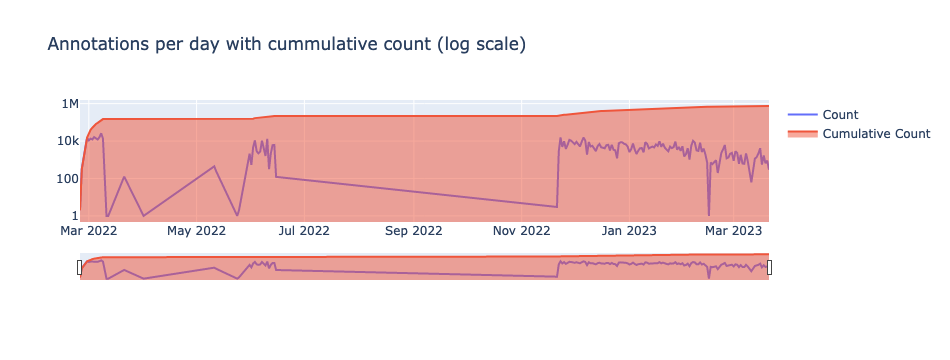

In [29]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=classifications_by_day["created_at"],
        y=classifications_by_day["count"],
        mode="lines",
        name="Count",
    )
)

fig.add_trace(
    go.Scatter(
        x=classifications_by_day["created_at"],
        y=classifications_by_day["cumulative_count"],
        mode="lines",
        name="Cumulative Count",
        fill="tozeroy",
    )
)

fig.update_xaxes(rangeslider_visible=True).update_yaxes(type="log")

fig.update_layout(
    barmode="group", title="Annotations per day with cummulative count (log scale)"
)

fig.show()

#### Annotations by user

In [30]:
classifications_by_user = classifications.value_counts("user_name").reset_index(
    name="count"
)

In [31]:
info(
    f"The workflow *{workflow_name}* has **{classifications_by_user.shape[0]}** different users."
)

>ℹ️ The workflow *How did machines change accidents?* has **1588** different users.

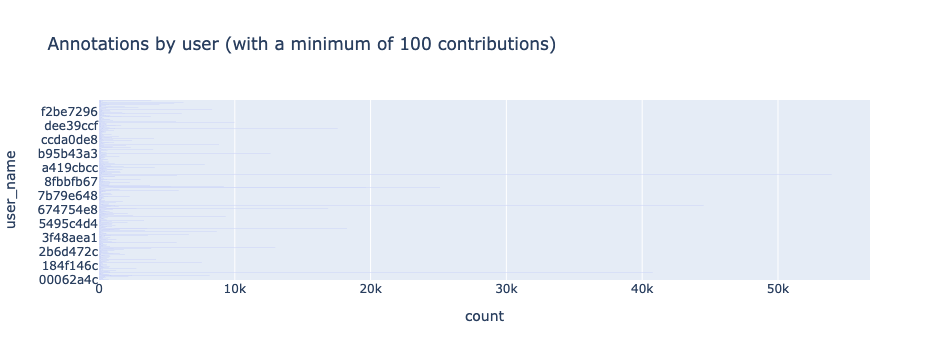

In [32]:
fig = classifications_by_user[classifications_by_user["count"] > 100].plot.bar(
    x="count",
    y="user_name",
    title="Annotations by user (with a minimum of 100 contributions)",
)
fig.update_layout(yaxis=dict(categoryorder="category ascending"))
fig.show()

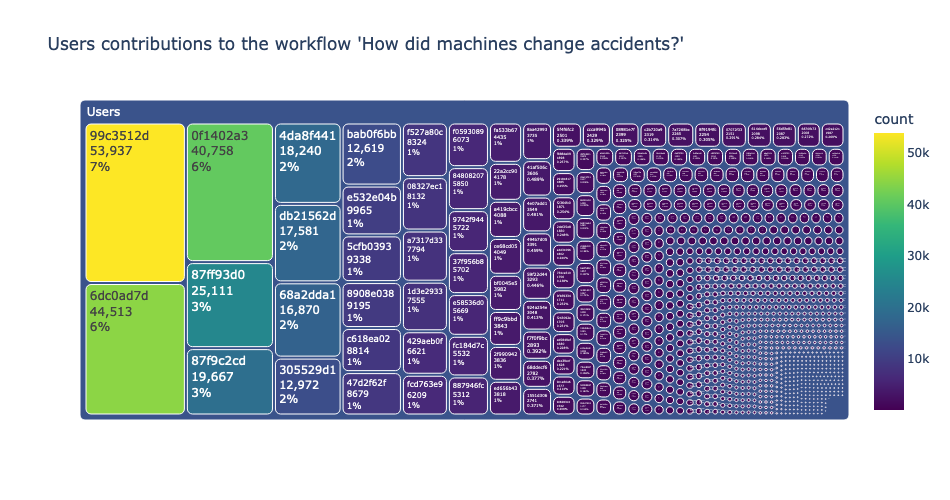

In [33]:
fig = px.treemap(
    classifications_by_user[classifications_by_user["count"] > 10],
    path=[px.Constant("Users"), "user_name"],
    values="count",
    color="count",
    color_continuous_scale="Viridis",
    title=f"Users contributions to the workflow '{workflow_name}'",
    height=500,
)
fig.update_traces(
    marker=dict(cornerradius=5),
    textinfo="label+value+percent root",
)
fig.show()

#### Subjects

In [34]:
subjects = subjects_df[subjects_df["workflow_id"] == workflow_id]
subjects.head(2)

subject_id_disambiguated  project_id  workflow_id  subject_set_id  \
subject_id                                                                     
73320307                      30701        9943        20921          102701   
73320308                      22231        9943        20921          102701   

                                                    locations  \
subject_id                                                      
73320307    {'0': 'https://panoptes-uploads.zooniverse.org...   
73320308    {'0': 'https://panoptes-uploads.zooniverse.org...   

            classifications_count  retired_at     retirement_reason  \
subject_id                                                            
73320307                        4  2022-06-02             consensus   
73320308                        5  2022-06-10  classification_count   

            created_at  updated_at  ... !original_metadata.newspaper title  \
subject_id                          ...                                      
73320307    2022-02-24  2022-11-09  ...                                      
73320308    2022-02-24  2022-11-09  ...                                      

           !original_metadata.!zooniverse_file_md5  \
subject_id                                           
73320307                                             
73320308                                             

           !original_metadata.!zooniverse_file_stem   !issue !article_id  \
subject_id                                                                 
73320307                                                                   
73320308                                                                   

           !textblock_id newspaper_date newspaper_place newspaper_title  
subject_id                                                               
73320307                                                                 
73320308                                                                 

[2 rows x 46 columns]

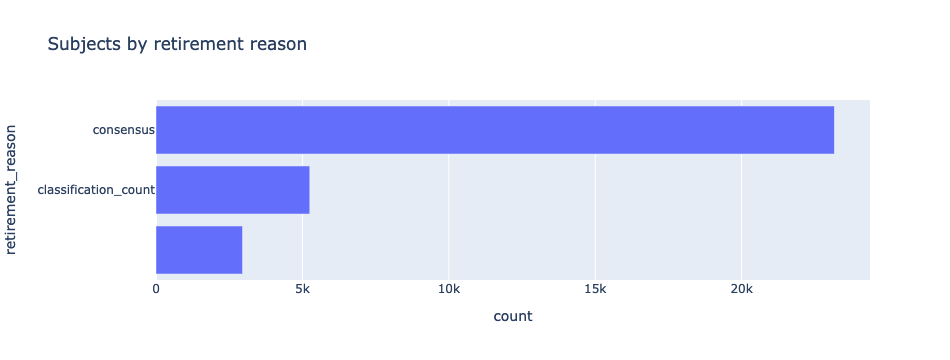

In [35]:
fig = px.bar(
    subjects.value_counts("retirement_reason").reset_index(name="count"),
    x="count",
    y="retirement_reason",
    title="Subjects by retirement reason",
)
fig.update_layout(yaxis=dict(categoryorder="category ascending"))
fig.show()

#### Subjects classification journey

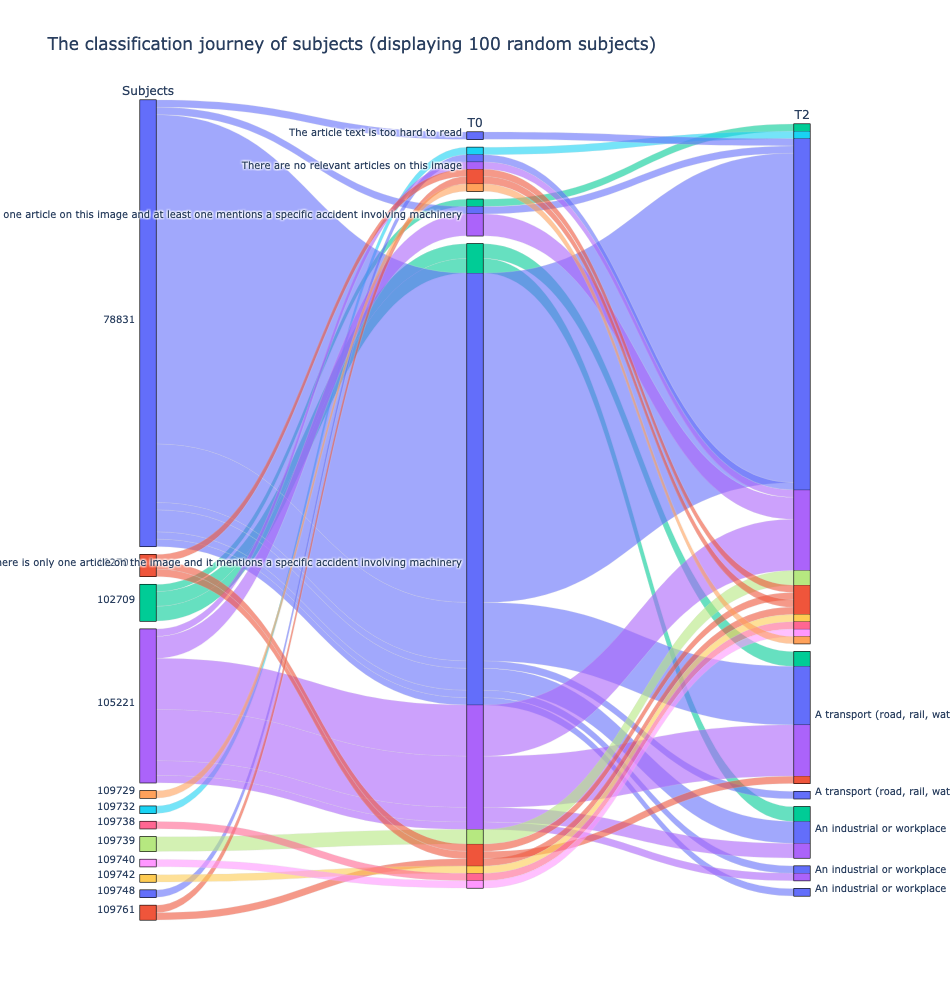

In [36]:
tasks = json.loads(workflow[workflow["tasks"] != {}].iloc[0]["tasks"])

dimensions = [k for k, v in tasks.items() if v["type"] != "drawing"]
dimensions.insert(0, "subject_set_id")
dimensions_options = [{"categoryorder": "category ascending"} for _ in dimensions]

if len(dimensions) > 1:
    journey_df = classifications.sample(n=100)

    colour_df = journey_df["subject_set_id"].copy()
    colour_index = colour_df.unique()
    colour_index.sort()

    palette = px.colors.qualitative.Plotly
    palette_len = len(palette)

    colours = colour_df.map(
        {v: palette[i % palette_len] for i, v in enumerate(colour_index)}
    )

    fig = (
        px.parallel_categories(
            journey_df,
            dimensions=dimensions,
            color=colours,
            labels={
                dimensions[0]: "Subjects",
            },
            height=1000,
            title="The classification journey of subjects (displaying 100 random subjects)",
        )
        .update_layout(margin=dict(l=100, r=100), showlegend=False)
        .update_traces(
            dimensions=dimensions_options,
            line=dict(shape="hspline"),
        )
    )
    fig.show()